# Simulating Cooling of Atoms in Optical Array

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from qutip import *

In [2]:
def check_operator_subsystem_dims(op, expected_dims, label="operator"):
    """
    Check if a QuTiP operator acts on the expected tensor product structure.
    
    Parameters:
        op : qutip.Qobj
            The operator to check.
        expected_dims : list of ints
            The expected Hilbert space dimensions for each subsystem (e.g., [2, 15] for atom ⊗ motion).
        label : str
            Label for print output (e.g., "Hamiltonian", "L_collapse").
    
    Returns:
        bool : True if dimensions match, False otherwise
    """
    actual_dims = []
    for d in op.dims[0]:
        actual_dims.append(d)
    if actual_dims == expected_dims:
        print(f"[OK] {label}: dims = {actual_dims} matches expected {expected_dims}")
        return True
    else:
        print(f"[ERROR] {label}: dims = {actual_dims} does NOT match expected {expected_dims}")
        return False


In [2]:
# Parameters
# Parameters (units: Γ = 1)
Gamma = 1.0                      # Natural linewidth
nu = 1         
eta = 0.05                     # Lamb-Dicke parameter
Omega = 0.05 * Gamma                  # Rabi frequency (weak driving)
N = 15                       # Number of motional states
Delta = 1.0                    # Laser detuning (red sideband)

# Identity operators
I_atom = qeye(2)
I_motion = qeye(N)

psi = tensor(basis(2, 0), basis(N, 0))  # Initial state |g, 0⟩. Dimensions should be [2, 15]

# Motional operators
a = destroy(N)            # Annihilation operator
adag = create(N)          # Creation operator
n_op = adag * a       # Phonon number operator

x_op = a + a.dag()  # Dimensionless position operator

g = basis(2, 0)          # Ground state |g>
e = basis(2, 1)          # Excited state |e>
sm = sigmam()
sp = sigmap() 
proj_e = basis(2,1) * basis(2,1).dag()  # |e⟩⟨e|

# Tensor operators for the full system
a_full = tensor(I_atom, a)
adag_full = tensor(I_atom, adag)
n_full = tensor(I_atom, n_op)
x_full = tensor(I_atom, x_op)

sm_full = tensor(sm, I_motion)
sp_full = tensor(sp, I_motion)
proj_e_full = tensor(proj_e, I_motion)


In [3]:
def get_c_ops(eta, Gamma):
    # Recoil operator
    recoil_plus = (1j * eta * x_full).expm()
    recoil_minus = (-1j * eta * x_full).expm()

    # Lowering operators
    L_plus = np.sqrt(Gamma) * recoil_plus * sm_full
    L_minus = np.sqrt(Gamma) * recoil_minus * sm_full
    c_ops = [L_plus, L_minus]
    return c_ops

def get_hamiltonian(Delta, nu, eta):
    recoil_plus = (1j * eta * x_full).expm()
    recoil_minus = (-1j * eta * x_full).expm()

    H = nu * n_full + Delta * proj_e_full - Omega/2 * (recoil_plus * sp_full + recoil_minus * sm_full)
    return H


Hamiltonian and collapse operators
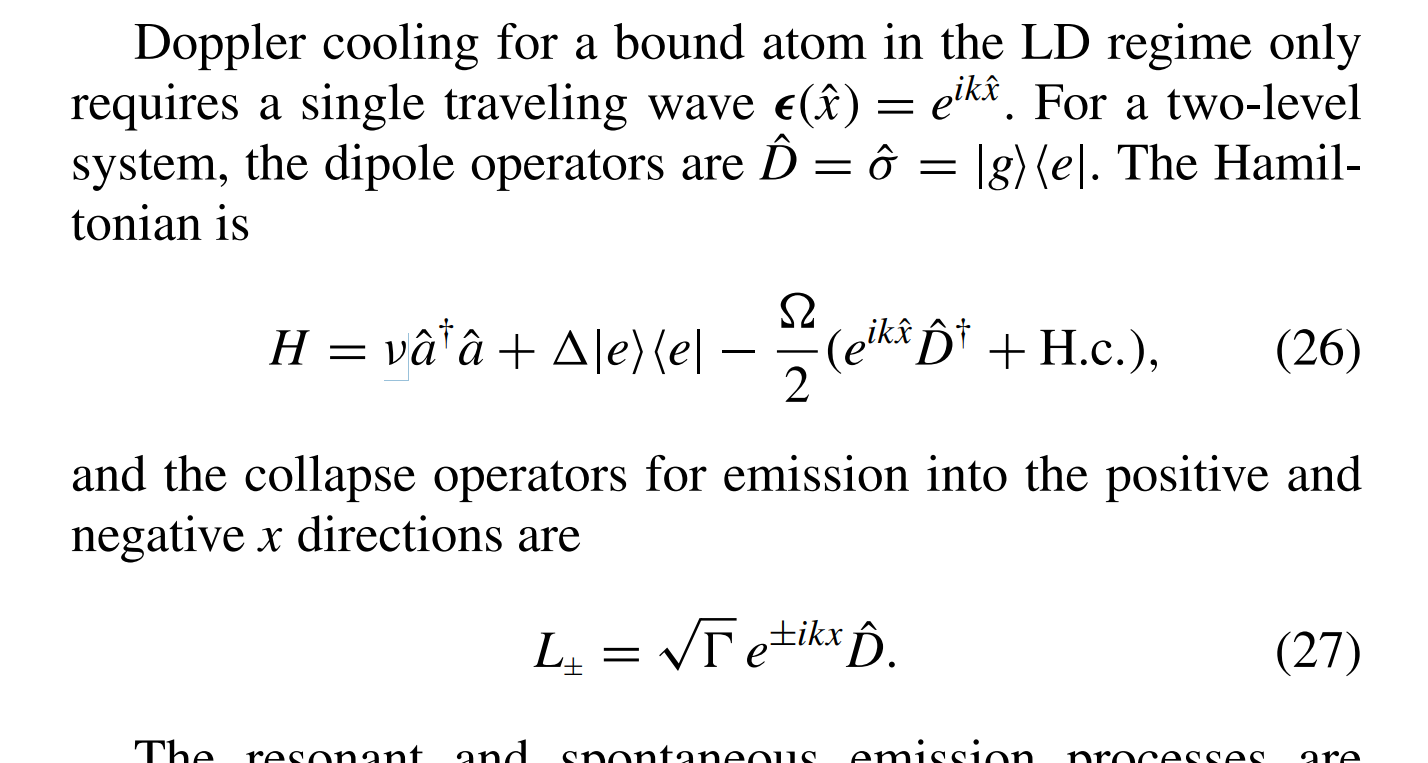

## Section III A: Sideband Cooling

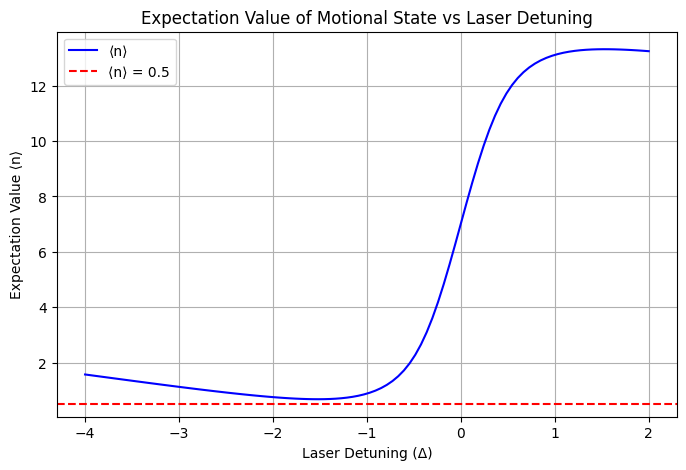

In [5]:
Delta_list = np.linspace(-4, 2, 100)  # Detunings to sweep over
n_expect = np.zeros(len(Delta_list))

# Calculate expectation values for different detunings
for i, Delta in enumerate(Delta_list):
    H = get_hamiltonian(Delta, nu, eta)
    c_ops = get_c_ops(eta, Gamma)
    rho_ss = steadystate(H, c_ops)
    n_expect[i] = expect(n_full, rho_ss)

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(Delta_list, n_expect, label='⟨n⟩', color='blue')
plt.axhline(y=0.5, color='red', linestyle='--', label='⟨n⟩ = 0.5')
plt.xlabel('Laser Detuning (Δ)')
plt.ylabel('Expectation Value ⟨n⟩')
plt.title('Expectation Value of Motional State vs Laser Detuning')
plt.legend()
plt.grid()
plt.show()

Figure 2C and 2D (starting with 2C, in the unresolved region)

In [26]:
nu_values_small = np.linspace(0.1, 1, 25)
Delta_values_small = np.linspace(-0.1, -1, 25)

# create a 10x10 array to store results
results_small = np.zeros((len(nu_values_small), len(Delta_values_small)))
for x, nu in enumerate(nu_values_small):
    for y, Delta in enumerate(Delta_values_small):
        H = get_hamiltonian(Delta, nu, eta)
        c_ops = get_c_ops(eta, Gamma)
        rho_ss = steadystate(H, c_ops)
        results_small[x, y] = expect(n_full, rho_ss)
print(results_small)

[[6.63689254 6.50527686 6.3780345  6.25610947 6.14029015 6.03119887
  5.92929046 5.83485843 5.74804723 5.66886872 5.59722111 5.53290874
  5.47566156 5.4251534  5.3810183  5.34286486 5.31028825 5.28288003
  5.26023606 5.24196251 5.22768033 5.2170284  5.20966566 5.20527225
  5.20355008]
 [6.50821229 6.33032662 6.15877764 5.99488799 5.83973177 5.69412333
  5.55862102 5.43354342 5.31899432 5.21489309 5.12100724 5.03698468
  4.96238378 4.8967003  4.83939035 4.78988953 4.74762816 4.71204321
  4.68258714 4.65873429 4.63998518 4.6258692  4.615946   4.60980588
  4.60706952]
 [6.38605542 6.16459636 5.95166852 5.74898245 5.55788004 5.37932612
  5.21392379 5.0619475  4.9233877  4.79800097 4.68536058 4.58490409
  4.49597558 4.4178614  4.34981933 4.29110133 4.24097074 4.19871465
  4.16365234 4.13514066 4.11257695 4.09540029 4.08309129 4.07517111
  4.07119978]
 [6.27165435 6.00977945 5.75883949 5.52093175 5.29763677 5.09001865
  4.89865929 4.72371656 4.56499573 4.4220249  4.2941273  4.18048608
  4.08

Plotting Figure 2C

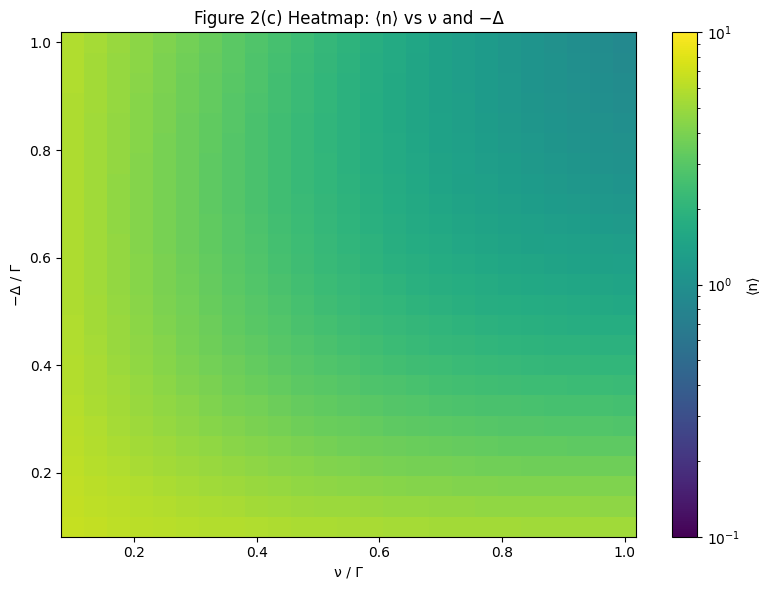

In [28]:
X_small, Y_small = np.meshgrid(nu_values_small / Gamma, -Delta_values_small / Gamma)
plt.figure(figsize=(8, 6))
# use pcolormesh
plt.pcolormesh(X_small, Y_small, results_small, shading='auto', cmap='viridis', norm=colors.LogNorm(vmin=0.1, vmax=10))
# plt.contourf(X1, Y1, results1, levels=50, cmap='viridis')#, norm=colors.LogNorm(vmin=0.1, vmax=10))
plt.colorbar(label='⟨n⟩')
plt.xlabel("ν / Γ")
plt.ylabel("−Δ / Γ")
plt.title("Figure 2(c) Heatmap: ⟨n⟩ vs ν and −Δ")
plt.tight_layout()
plt.show()





## Figure 2D

In [9]:
nu_values = np.linspace(0.1, 10, 100)
Delta_values = np.linspace(-0.1, -10, 100)

# create a 10x10 array to store results
results_full = np.zeros((len(nu_values), len(Delta_values)))
for x, nu in enumerate(nu_values):
    for y, Delta in enumerate(Delta_values):
        H = get_hamiltonian(Delta, nu, eta)
        c_ops = get_c_ops(eta, Gamma)
        rho_ss = steadystate(H, c_ops)
        n_exp = expect(n_full, rho_ss)
        if n_exp < 0:
            print("Error! Negative expectation value detected. Trying again")
            H = get_hamiltonian(Delta - .01, nu + .01, eta)
            c_ops = get_c_ops(eta, Gamma)
            rho_ss = steadystate(H, c_ops)
            n_exp = expect(n_full, rho_ss)
            if n_exp < 0:
                print("Error! Negative expectation value detected again. Exiting.")
                n_exp = 0

        results_full[x, y] = n_exp
print(results_full)

[[6.63689254 6.29610831 5.99641359 ... 6.62351885 6.62723378 6.63087696]
 [6.30886109 5.66892356 5.12072385 ... 6.25027206 6.25760725 6.26480258]
 [6.03981698 5.16601353 4.44058003 ... 5.88337992 5.89415195 5.90472294]
 ...
 [7.06581435 7.05736528 7.04792631 ... 0.01297708 0.01287236 0.0130206 ]
 [7.06609759 7.05789635 7.04873409 ... 0.01307972 0.01271781 0.01261743]
 [7.06637039 7.05840742 7.0495112  ... 0.01344142 0.01281867 0.01246622]]


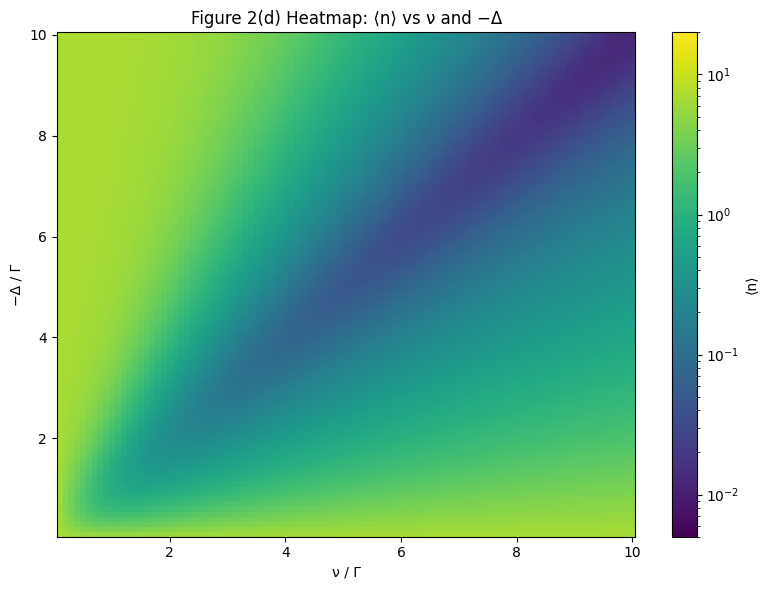

In [20]:
# Using pcolormesh, plot the data in a log scale
X_full, Y_full = np.meshgrid(nu_values / Gamma, -Delta_values / Gamma)
plt.figure(figsize=(8, 6))
plt.pcolormesh(X_full, Y_full, results_full, shading='auto', cmap='viridis', norm=colors.LogNorm(vmin=0.005, vmax=20))
plt.colorbar(label='⟨n⟩')
plt.xlabel("ν / Γ")
plt.ylabel("−Δ / Γ")
plt.title("Figure 2(d) Heatmap: ⟨n⟩ vs ν and −Δ")
plt.tight_layout()
plt.show()

## Figure 2e

In [12]:
eta_vals = [0.01, 0.1, 0.5, 0.7, 1.0]

nu_vals = np.linspace(0.1, 10, 100)

# create a 5x100 array to store results for each eta value
results_etas = np.zeros((len(eta_vals), len(nu_vals)))

for i, eta in enumerate(eta_vals):
    for j, nu in enumerate(nu_vals):
        Delta = -nu
        H = get_hamiltonian(Delta, nu, eta)
        c_ops = get_c_ops(eta, Gamma)
        rho_ss = steadystate(H, c_ops)
        results_etas[i, j] = expect(n_full, rho_ss)


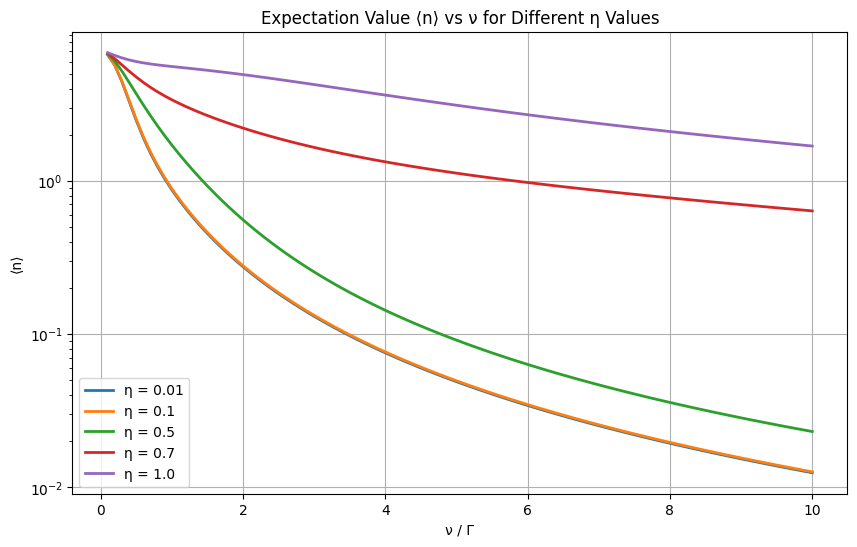

In [13]:

# Plotting the results for different eta values
plt.figure(figsize=(10, 6))
for i, eta in enumerate(eta_vals):
    plt.plot(nu_vals / Gamma, results_etas[i], label=f'η = {eta}', linewidth=2, )
plt.xlabel('ν / Γ')
plt.ylabel('⟨n⟩')
plt.yscale('log')
plt.title('Expectation Value ⟨n⟩ vs ν for Different η Values')
plt.legend()
plt.grid()
plt.show()

## Section III C: Sideband Cooling with Variable Frequencies

In [279]:
# Parameters
# Parameters (units: Γ = 1)
N = 15                       # Number of motional states

# Identity operators
I_atom = qeye(2)
I_motion = qeye(N)


psi = tensor(basis(2, 0), basis(N, 0))  # Initial state |g, 0⟩. Dimensions should be [2, 15]

# Motional operators
a = destroy(N)            # Annihilation operator
adag = create(N)          # Creation operator
n_op = adag * a       # Phonon number operator
x_op = a + a.dag()  # Dimensionless position operator

g = basis(2, 0)          # Ground state |g>
e = basis(2, 1)          # Excited state |e>
sm = sigmam()
sp = sigmap()
proj_g = g * g.dag()  # |g⟩⟨g|
proj_e = e * e.dag()  # |e⟩⟨e|

# Tensor operators for the full system
a_full = tensor(I_atom, a)
adag_full = tensor(I_atom, adag)
n_full = tensor(I_atom, n_op)
x_full = tensor(I_atom, x_op)

sm_full = tensor(sm, I_motion)
sp_full = tensor(sp, I_motion)
proj_e_full = tensor(proj_e, I_motion)
proj_g_full = tensor(proj_g, I_motion)


def get_c_ops(eta, Gamma):
    # Recoil operator
    recoil_plus = (1j * eta * x_full).expm()
    recoil_minus = (-1j * eta * x_full).expm()

    L_plus  = np.sqrt(Gamma) * recoil_plus  * sm_full
    L_minus = np.sqrt(Gamma) * recoil_minus * sm_full

    c_ops = [L_plus, L_minus]
    
    return c_ops

def get_hamiltonian(Delta, nu, nu_e, eta):
    recoil_plus = (1j * eta * x_full).expm()
    
    # squeeze parameter and operator
    r = 0.5 * np.log(nu_e / nu)
    S = squeeze(N, r)
    S_full = tensor(I_atom, S)

    H_vib = nu * n_full * proj_g_full + (nu_e * S_full.dag() * n_full * S_full * proj_e_full)
    H_int = -Omega/2 * (recoil_plus * sp_full + (recoil_plus * sp_full).dag())


    H = H_vib + Delta * proj_e_full + H_int
    return H


Plotting sideband cooling with different excited vs trapping frequencies.

First, figure 3b

In [276]:
N_simulation_steps = 20

nu_vals = np.array([0.5, 1.0, 2.0, 5.0], dtype=float)
nu_e_vals = np.array([np.linspace(nu * 0.5, nu * 2, N_simulation_steps) for nu in nu_vals])
cooling_results = np.zeros((len(nu_vals), N_simulation_steps))

Gamma = 1.0
eta = 0.1                    # Lamb-Dicke parameter
Omega = 0.05 * Gamma                  # Rabi frequency (weak driving)

In [280]:
for i, nu in enumerate(nu_vals):
    Delta = -nu
    for j, nu_e in enumerate(nu_e_vals[i]):
        H = get_hamiltonian(Delta, nu, nu_e, eta)
        c_ops = get_c_ops(eta, Gamma)
        rho_ss = steadystate(H, c_ops)
        cooling_results[i, j] = expect(n_full, rho_ss)

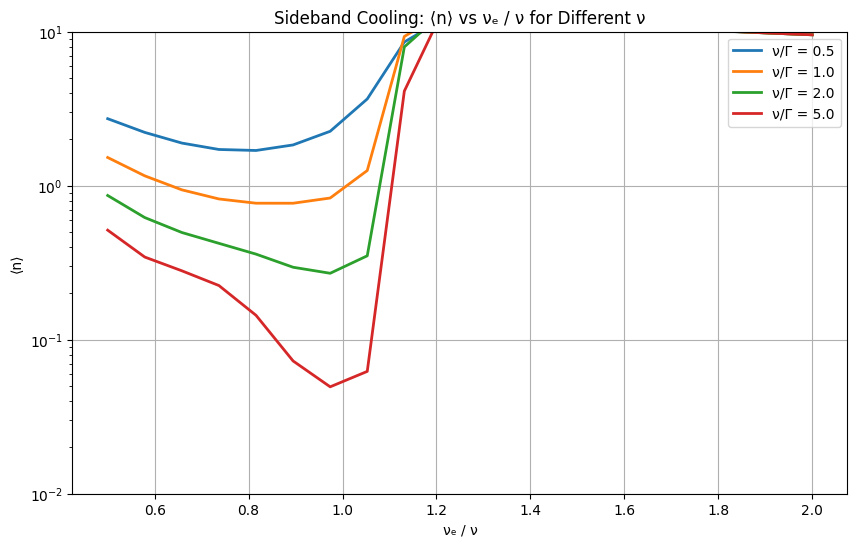

In [281]:
plt.figure(figsize=(10,6))
plt.yscale('log')
for i, nu in enumerate(nu_vals):
    plt.plot((nu_e_vals[i] / nu), cooling_results[i], label=f'ν/Γ = {nu/Gamma}', linewidth=2)
# label the plot
plt.xlabel('νₑ / ν')
plt.ylabel('⟨n⟩')
plt.ylim(.01,10)
plt.title('Sideband Cooling: ⟨n⟩ vs νₑ / ν for Different ν')
plt.legend()
plt.grid()
plt.show()

Figure 3C

In [263]:
Delta_vals = np.linspace(-5, -0.5, 100)
nu = 2
nu_e_vals = np.array([0.8, 1.0, 1.2], dtype=float) * nu


In [265]:
cooling_results_delta = np.zeros((len(nu_e_vals), len(Delta_vals)))

for i, nu_e in enumerate(nu_e_vals):
    for j, Delta in enumerate(Delta_vals):
        H = get_hamiltonian(Delta, nu, nu_e, eta)
        c_ops = get_c_ops(eta, Gamma)
        rho_ss = steadystate(H, c_ops)
        cooling_results_delta[i, j] = expect(n_full, rho_ss)

Given that $$0 = \eta^2[\langle n \rangle (A_+ - A_-) + A_+] + 4r^2 [\langle n \rangle ^2 (B_+-B_-) + B_+(2\langle n \rangle + 1)]$$,
plot an analytical solution for $\langle n \rangle$

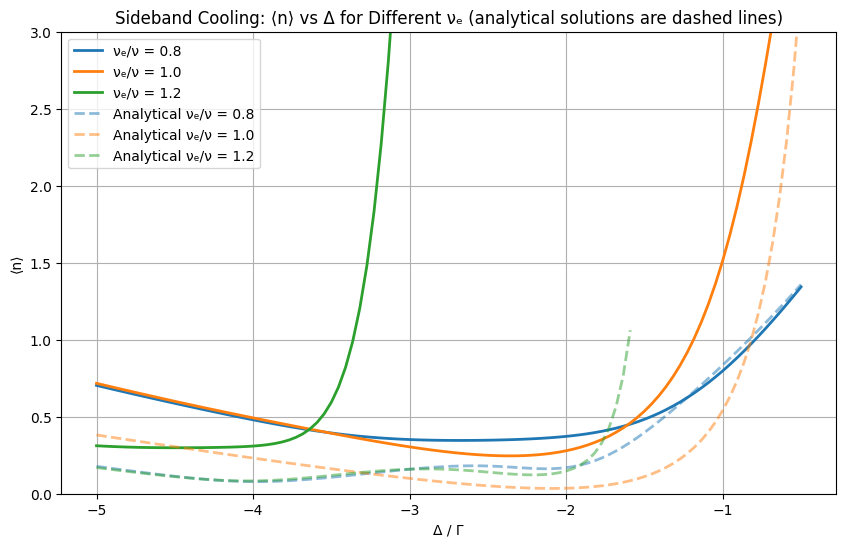

In [266]:
# analytical solution
def R(Delta_n, Gamma, Omega):
    return Gamma * (Omega**2/4) / (Delta_n**2 +(Gamma/2) ** 2)

def T(Delta_n, Gamma, Omega):
    return np.sqrt(Gamma)*(Omega/2)/(Delta_n-1j*Gamma/2)
# Analytical solution for <n> from the given quadratic equation:
# 0 = eta^2 [n (A_+ - A_-) + A_+] + 4r^2 [n^2 (B_+ - B_-) + B_+ (2n + 1)]
def solve_self_consistent_n(Delta, nu, nu_e, eta, r, Gamma, Omega, alpha=1/3, tol=1e-5, max_iter=50000):
    n_guess = 0.5
    for _ in range(max_iter):
        # Step 1: detuning with n-dependence
        Delta_n = Delta + n_guess * (nu_e - nu)

        # Step 2: A± and B± based on Delta_n
        A_plus = R(Delta_n - nu, Gamma, Omega) + alpha * R(Delta_n, Gamma, Omega)
        A_minus = R(Delta_n + nu, Gamma, Omega) + alpha * R(Delta_n, Gamma, Omega)
        Tn = T(Delta_n, Gamma, Omega)
        B_plus = np.abs(Tn - T(Delta_n - 2*nu, Gamma, Omega))**2
        B_minus = np.abs(Tn - T(Delta_n + 2*nu, Gamma, Omega))**2

        # Step 3: solve quadratic equation for ⟨n⟩
        a = 4 * r**2 * (B_plus - B_minus)
        b = eta**2 * (A_plus - A_minus) + 8 * r**2 * B_plus
        c = eta**2 * A_plus + 4 * r**2 * B_plus
        D = b**2 - 4*a*c

        if D < 0:
            return np.nan  # unphysical
        n1 = (-b + np.sqrt(D)) / (2*a) if a != 0 else -c / b
        n2 = (-b - np.sqrt(D)) / (2*a) if a != 0 else -c / b
        if n1 and n2 < 0:
            return np.nan
        n_new = min(x for x in (n1, n2) if x >= 0)  # choose physical root

        # Step 4: check convergence
        if abs(n_new - n_guess) < tol:
            return n_new
        n_guess = n_new

    return n_guess  # fallback after max_iter

# Example: plot for the same Delta_vals and nu_e_vals as in the simulation
eta_val = 0.1 # Lamb-Dicke parameter
nu_val = 2
Gamma_val = 1
Omega_val = 0.05 * Gamma_val  # Rabi frequency (weak driving)

analytical_results = np.zeros((len(nu_e_vals), len(Delta_vals)))

for i, nu_e in enumerate(nu_e_vals):
    r_val = 0.5 * np.log(nu_e / nu_val)
    for j, Delta in enumerate(Delta_vals):
        analytical_results[i, j] = solve_self_consistent_n(
            Delta, nu_val, nu_e, eta_val, r_val, Gamma_val, Omega_val
        )

# Plot analytical solution
plt.figure(figsize=(10, 6))
for i, nu_e in enumerate(nu_e_vals):
    plt.plot(Delta_vals / Gamma, cooling_results_delta[i], label=f'νₑ/ν = {nu_e/nu}', linewidth=2, color=f'C{i}')
for i, nu_e in enumerate(nu_e_vals):
    plt.plot(Delta_vals / Gamma, analytical_results[i], '--', label=f'Analytical νₑ/ν = {nu_e/nu}', linewidth=2, color=f'C{i}', alpha=0.5)

plt.xlabel('Δ / Γ')
plt.ylabel('⟨n⟩')
plt.title('Sideband Cooling: ⟨n⟩ vs Δ for Different νₑ (analytical solutions are dashed lines)')
plt.ylim(0, 3)
plt.legend()
plt.grid()
plt.show()